In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log
import copy

columns = ['date', 'time', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage']
df = pd.read_csv('./datasets/Intellab.txt', sep=" ", header=None, names=columns)
df

,date,time,epoch,moteid,temperature,humidity,light,voltage
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964
...,...,...,...,...,...,...,...,...
2313677,2004-04-02,01:14:54.164318,61274,NaN,NaN,NaN,NaN,NaN
2313678,2004-04-02,01:17:53.670524,61275,NaN,NaN,NaN,NaN,NaN
2313679,2004-04-02,01:20:52.807972,61276,NaN,NaN,NaN,NaN,NaN
2313680,2004-04-02,01:26:53.950342,61278,NaN,NaN,NaN,NaN,NaN


In [2]:
df.dropna(subset=['temperature','humidity', 'light'], inplace=True)
df['moteid'] = df['moteid'].astype('int')
# Drop noisy values
df = df[df['humidity']>=0]

In [3]:
# Bin the values
def discretize(df, bin_size):
    bins = np.arange(df.min(), df.max() + bin_size, bin_size)
    return pd.cut(df, bins, labels=False, include_lowest=True)

df['temp'] = discretize(df['temperature'].copy(), 2)
df['hum'] = discretize(df['humidity'].copy(), 5)
df['lgt'] = discretize(df['light'].copy(), 100)

<ipython-input-3-fbc6b3f8bbe9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = discretize(df['temperature'].copy(), 2)
<ipython-input-3-fbc6b3f8bbe9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hum'] = discretize(df['humidity'].copy(), 5)
<ipython-input-3-fbc6b3f8bbe9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [4]:
prob_temp = pd.DataFrame(df.groupby(['moteid','temp'])[['temp']].count().rename(columns={'temp':'temp_value'}).to_records())
temp_total = df.groupby(['moteid'],as_index=False)[['temp']].count().rename(columns={'temp':'temp_total'})
prob_temp = prob_temp.merge(temp_total,how='left',on='moteid')
prob_temp['probs'] = prob_temp.apply(lambda x: x['temp_value']/float(x['temp_total']),axis=1)
prob_temp['entropy'] = prob_temp.apply(lambda x: -x['probs']*log(x['probs']),axis=1)
prob_temp

,moteid,temp,temp_value,temp_total,probs,entropy
0,1,27,479,38664,0.012389,0.054399
1,1,28,4403,38664,0.113879,0.247415
2,1,29,11765,38664,0.304288,0.362036
3,1,30,12157,38664,0.314427,0.363793
4,1,31,4417,38664,0.114241,0.247839
...,...,...,...,...,...,...
2438,58,29,1187,4497,0.263954,0.351581
2439,58,30,1228,4497,0.273071,0.354453
2440,58,31,599,4497,0.133200,0.268518
2441,58,32,30,4497,0.006671,0.033422


In [5]:
prob_hum = pd.DataFrame(df.groupby(['moteid','hum'])[['hum']].count().rename(columns={'hum':'hum_value'}).to_records())
hum_total = df.groupby(['moteid'],as_index=False)[['hum']].count().rename(columns={'hum':'hum_total'})
prob_hum = prob_hum.merge(hum_total,how='left',on='moteid')
prob_hum['probs'] = prob_hum.apply(lambda x: x['hum_value']/float(x['hum_total']),axis=1)
prob_hum['entropy'] = prob_hum.apply(lambda x: -x['probs']*log(x['probs']),axis=1)
prob_hum

,moteid,hum,hum_value,hum_total,probs,entropy
0,1,0,20,38664,0.000517,0.003914
1,1,1,21,38664,0.000543,0.004083
2,1,2,16,38664,0.000414,0.003224
3,1,3,49,38664,0.001267,0.008454
4,1,4,324,38664,0.008380,0.040072
...,...,...,...,...,...,...
606,58,6,556,4497,0.123638,0.258453
607,58,7,1288,4497,0.286413,0.358108
608,58,8,1447,4497,0.321770,0.364861
609,58,9,547,4497,0.121637,0.256254


In [6]:
prob_lgt = pd.DataFrame(df.groupby(['moteid','lgt'])[['lgt']].count().rename(columns={'lgt':'lgt_value'}).to_records())
lgt_total = df.groupby(['moteid'],as_index=False)[['lgt']].count().rename(columns={'lgt':'lgt_total'})
prob_lgt = prob_lgt.merge(lgt_total,how='left',on='moteid')
prob_lgt['probs'] = prob_lgt.apply(lambda x: x['lgt_value']/float(x['lgt_total']),axis=1)
prob_lgt['entropy'] = prob_lgt.apply(lambda x: -x['probs']*log(x['probs']),axis=1)
prob_lgt

,moteid,lgt,lgt_value,lgt_total,probs,entropy
0,1,0,23158,38664,0.598955,0.307006
1,1,1,3812,38664,0.098593,0.228416
2,1,2,2883,38664,0.074565,0.193578
3,1,3,3432,38664,0.088765,0.214967
4,1,4,2832,38664,0.073246,0.191461
...,...,...,...,...,...,...
835,58,13,2,4497,0.000445,0.003433
836,58,14,10,4497,0.002224,0.013584
837,58,15,11,4497,0.002446,0.014709
838,58,16,17,4497,0.003780,0.021086


In [7]:
temp_entropy = prob_temp.groupby('moteid')['entropy'].sum().to_frame()
temp_entropy.rename(columns={'entropy':'entropy_temp'},inplace=True)
hum_entropy = prob_hum.groupby('moteid')['entropy'].sum().to_frame()
hum_entropy.rename(columns={'entropy':'entropy_hum'},inplace=True)
lgt_entropy = prob_lgt.groupby('moteid')['entropy'].sum().to_frame()
lgt_entropy.rename(columns={'entropy':'entropy_lgt'},inplace=True)

In [8]:
entropy = pd.merge(temp_entropy,hum_entropy,how='left',left_index=True,right_index=True)
entropy = entropy.merge(lgt_entropy,how='left',left_index=True,right_index=True)

In [9]:
def objective_function(S,df):
    sum = 0
    for j,i in enumerate(S):
        column = df.columns[j]
        sum += df.loc[i,column].sum()
    return sum

In [ ]:
def calculate_marginal_difference(S,df, e):
    types = len(S)
    base = [objective_function(S,df)]*types
    next = []
    for i in range(types):
        new_set = copy.deepcopy(S)
        new_set[i].append(e)
        next.append(objective_function(new_set,df))
    margin = np.subtract(next,base).tolist()
    return margin

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import copy

class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

def value_function_approximation(f, B, df, hidden_dim, learning_rate, gamma, epsilon, num_episodes, device):
    num_topics = len(B)  # Number of topics
    num_elements = len(df)  # Number of elements
    state_dim = num_topics  # Input dimension for the neural network

    # Initialize the DQN
    model = DQN(state_dim, hidden_dim, num_topics).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    objective_values = []
    for episode in range(num_episodes):
        S = [deque() for _ in range(num_topics)]  # Initialize sets S
        budget = B.copy()
        for t in range(num_elements):
            state = np.array(budget, dtype=np.float32)
            #print(f'State: {state}')
            state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)
            #print(f'State Tensor: {state_tensor}')

            # Epsilon-greedy policy for exploration
            if np.random.rand() < epsilon:
                #print('Random Action')
                action = np.random.randint(num_topics)
            else:
                #print('Not Random Action')
                with torch.no_grad():
                    q_values = model(state_tensor)
                    #print(f'Q values: {q_values}')
                    action = torch.argmax(q_values).item()
                    #print(f'Action: {action}')

            # Perform the chosen action and observe the reward
            if budget[action] >0:
                #print(f'Item will not be replaced')

                #Calculate reward
                reward = calculate_marginal_difference(S,df,df.index[t])[action]

                S[action].append(df.index[t])

                # Update budget (B) based on the chosen action
                budget[action] -= 1

                # Find Next State and store it for gradient computation
                next_state = np.array(budget, dtype=np.float32)
                next_state_tensor = torch.from_numpy(next_state).unsqueeze(0).to(device)
                #print(f'New Set: {S}')
            else:
                #print(f'Item will be replaced')
                #print(f'Set: {S[action]}')
                #print(f'Budged: {B[action]}')

                # Choose the item to be replaced based on the agent's strategy
                current_value = f(S,df)
                replace_index = choose_replacement_strategy(S[action], action, df)
                #print(f'Replace Index')
                S[action][replace_index] = df.index[t]
                next_value = f(S,df)
                reward = next_value -current_value
                next_state = np.array(budget, dtype=np.float32)
                next_state_tensor = torch.from_numpy(next_state).unsqueeze(0).to(device)

            # Update the target Q-value using the maximum over next state's Q-values
            with torch.no_grad():
                next_q_values = model(next_state_tensor)
                max_next_q_value, _ = torch.max(next_q_values, dim=1)
                target_q_value = reward + gamma * max_next_q_value

            # Calculate the current Q-value for the chosen action
            q_values = model(state_tensor)
            current_q_value = q_values[0, action]
            #print(q_values)

            # Update the DQN by minimizing the TD error
            #print(f'Current Q value: {current_q_value}')
            #print(f'Target Q value: {target_q_value}')
            loss = loss_fn(current_q_value.unsqueeze(0), target_q_value)
            #print(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print(model.fc1.weight.grad) 

        # Print episode information
        print("Episode:", episode + 1, "Objective Value:", f(S,df))
        objective_values.append(f(S,df))
        #print(f'Set: {S}')

    return model, objective_values

def choose_replacement_strategy(set, action, df):
    #print(f'Replacement Strategy')
    #print(f'Set: {set}, Action:{action}')
    #print(f'Sets: {set}')
    influence_values = [calculate_influence_value(set,action,item,df) for item in set]
    #print(f'Influence Values: {influence_values}')
    replace_index = np.argmin(influence_values)
    #print(f'Replace Index: {replace_index}')
    return replace_index

def calculate_influence_value(set,action,item, df):
    #print(f'Influence Values: Set:{set}, Action: {action}, Item: {item}')
    new_set = copy.deepcopy(set)
    new_set.remove(item)
    sum = 0
    #print(new_set)
    for i in new_set:
        column = df.columns[action]
        sum += df.loc[i,column].sum()
    #print(f'Sum: {sum}')
    return sum

In [101]:
# Set the hyperparameters
hidden_dim = 128
learning_rate = 0.001
gamma = 0.9
epsilon = 0.1
num_episodes = 1000

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare your data
B = [5, 5, 5]  # Initial budgets for each topic
# Define your objective function f
f = objective_function
V = len(df)

# Train the DQN model
model, obj_values = value_function_approximation(f, B, entropy, hidden_dim, learning_rate, gamma, epsilon, num_episodes,device)

Episode: 1 Objective Value: 17.991253724957215
Episode: 2 Objective Value: 22.74718829531011
Episode: 3 Objective Value: 23.681447743984965
Episode: 4 Objective Value: 23.390308717248384
Episode: 5 Objective Value: 24.165277845257194
Episode: 6 Objective Value: 23.64322573529087
Episode: 7 Objective Value: 21.63786502027076
Episode: 8 Objective Value: 23.250850645121986
Episode: 9 Objective Value: 23.667097928273773
Episode: 10 Objective Value: 22.932793848239946
Episode: 11 Objective Value: 22.083693577459375
Episode: 12 Objective Value: 23.20182667570253
Episode: 13 Objective Value: 24.06430423879909
Episode: 14 Objective Value: 23.10781908060184
Episode: 15 Objective Value: 24.18274609107217
Episode: 16 Objective Value: 23.871797153811237
Episode: 17 Objective Value: 23.423430957307612
Episode: 18 Objective Value: 24.586232958714632
Episode: 19 Objective Value: 22.557069243909766
Episode: 20 Objective Value: 24.271163058166582
Episode: 21 Objective Value: 24.094181676569193
Episode:

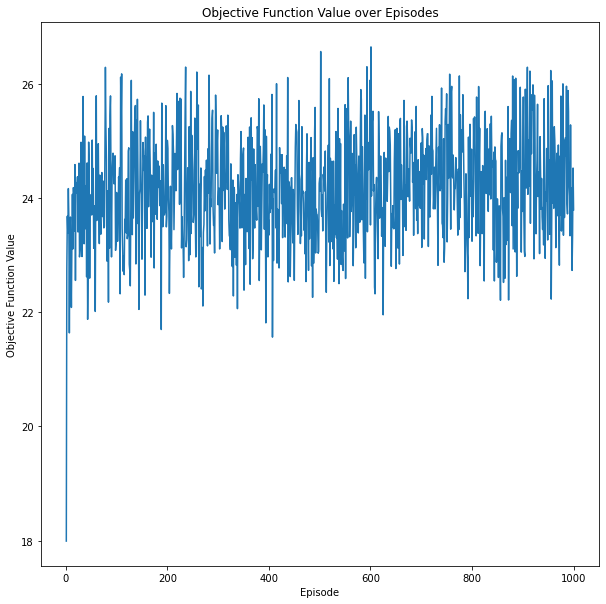

In [103]:
# Plot the graph of the objective function values
plt.figure(figsize=(10,10))
plt.plot(range(1, num_episodes + 1), obj_values)
plt.xlabel("Episode")
plt.ylabel("Objective Function Value")
plt.title("Objective Function Value over Episodes")
plt.show()